# Notebook 04 — Robust Backtest (Top-K + Custos + Turnover)

Este notebook transforma as previsões OOS (`preds_oos.parquet`) em estratégias mensais e mede performance.

Estratégias:
- Long-only: compra Top-K por `y_pred`
- Long-short: compra Top-K e vende Bottom-K por `y_pred` (market-neutral)

Realismo incluído:
- Rebalanceamento mensal
- Turnover (quanto a carteira muda de um mês pro outro)
- Custo proporcional ao turnover (default: 0.20% por 100% de giro)

Outputs:
- Equity curve
- Retorno acumulado, Sharpe, Max Drawdown
- Hit rate vs benchmark (média do universo)
- Comparação por K

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

PRED_PATH = "../data/processed/preds_oos_linear.parquet"
if not os.path.exists(PRED_PATH):
    raise FileNotFoundError(f"Não encontrei {PRED_PATH}. Rode o Notebook 03 e gere esse arquivo.")

preds = pd.read_parquet(PRED_PATH).copy()

# Segurança
preds["date"] = pd.to_datetime(preds["date"], errors="coerce")
preds = preds.dropna(subset=["date", "ticker", "y_true", "y_pred"]).copy()
preds["ticker"] = preds["ticker"].astype(str).str.upper().str.strip()
preds["year_month"] = preds["date"].dt.to_period("M")

print("Shape preds:", preds.shape)
print("Meses:", preds["year_month"].nunique())
print("Tickers:", preds["ticker"].nunique())
preds.head()

Shape preds: (156068, 6)
Meses: 251
Tickers: 38


,date,ticker,year_month,y_true,y_pred,fold
0,2005-03-01 03:00:00,ABEV3,2005-03,-0.195397,0.127966,1
1,2005-03-01 03:00:00,AXIA3,2005-03,-0.046996,0.040972,1
2,2005-03-01 03:00:00,AXIA6,2005-03,-0.025366,0.022019,1
3,2005-03-01 03:00:00,BBAS3,2005-03,-0.029832,0.013322,1
4,2005-03-01 03:00:00,BBDC3,2005-03,-0.068154,0.010507,1


In [20]:
# =========================================================
# CONVERTER PREDS DIÁRIAS -> PREDS MENSAIS (1 linha por ticker/mês)
# Escolha: primeiro pregão do mês (rebalance no início do mês)
# =========================================================

preds = preds.sort_values(["ticker", "date"]).copy()
preds["year_month"] = preds["date"].dt.to_period("M")

# pega a primeira data disponível de cada ticker em cada mês
preds_m = (
    preds.sort_values(["year_month", "ticker", "date"])
         .groupby(["year_month", "ticker"], as_index=False)
         .first()
)

print("Antes (diário):", preds.shape)
print("Depois (mensal):", preds_m.shape)

# sanity check: não pode ter duplicatas agora
dups = preds_m.duplicated(subset=["year_month", "ticker"]).sum()
print("Duplicatas (year_month, ticker):", dups)

preds_m.head()

Antes (diário): (156068, 6)
Depois (mensal): (7635, 6)
Duplicatas (year_month, ticker): 0


,year_month,ticker,date,y_true,y_pred,fold
0,2005-03,ABEV3,2005-03-01 03:00:00,-0.195397,0.127966,1
1,2005-03,AXIA3,2005-03-01 03:00:00,-0.046996,0.040972,1
2,2005-03,AXIA6,2005-03-01 03:00:00,-0.025366,0.022019,1
3,2005-03,BBAS3,2005-03-01 03:00:00,-0.029832,0.013322,1
4,2005-03,BBDC3,2005-03-01 03:00:00,-0.068154,0.010507,1


In [21]:
# Benchmark simples: retorno médio do universo (equal-weight) por mês
bench = preds_m.groupby("year_month")["y_true"].mean().rename("bench_ret").to_frame()
bench.head()

,bench_ret
year_month,
2005-03,-0.066981
2005-04,-0.086786
2005-05,0.064918
2005-06,0.005954
2005-07,0.038935


In [22]:
def make_weights_long_only(group: pd.DataFrame, k: int) -> pd.Series:
    """Pesos iguais no Top-K (soma = 1)."""
    top = group.sort_values("y_pred", ascending=False).head(k)
    w = pd.Series(0.0, index=group["ticker"])
    w.loc[top["ticker"]] = 1.0 / len(top)
    return w

def make_weights_long_short(group: pd.DataFrame, k: int) -> pd.Series:
    """
    Long Top-K e Short Bottom-K.
    Pesos: +1/K nos top, -1/K nos bottom. Soma = 0.
    """
    ranked = group.sort_values("y_pred", ascending=False)
    top = ranked.head(k)
    bot = ranked.tail(k)
    w = pd.Series(0.0, index=group["ticker"])
    w.loc[top["ticker"]] = 1.0 / len(top)
    w.loc[bot["ticker"]] = -1.0 / len(bot)
    return w

def turnover(w_prev: pd.Series, w_now: pd.Series) -> float:
    """
    Turnover padrão: 0.5 * sum(|w_t - w_{t-1}|).
    - Long-only: turnover ∈ [0, 1]
    - Long-short: turnover pode ser >1 dependendo da rotação
    """
    # alinhar índices (tickers)
    idx = w_prev.index.union(w_now.index)
    a = w_prev.reindex(idx).fillna(0.0)
    b = w_now.reindex(idx).fillna(0.0)
    return 0.5 * float(np.abs(b - a).sum())

def portfolio_return(group: pd.DataFrame, w: pd.Series) -> float:
    """
    Retorno do portfólio no mês usando y_true (retorno futuro já alinhado).
    r = sum(w_i * y_true_i)
    """
    rmap = group.set_index("ticker")["y_true"]
    # garantir alinhamento
    w2 = w.reindex(rmap.index).fillna(0.0)
    return float((w2 * rmap).sum())

def backtest(preds: pd.DataFrame, k: int, mode: str, cost_per_1_turnover: float = 0.002) -> pd.DataFrame:
    """
    mode: 'long' ou 'ls'
    cost_per_1_turnover: custo aplicado por 100% de turnover no mês.
      Ex: 0.002 = 0.20% por giro completo.
    """
    rows = []
    w_prev = pd.Series(dtype=float)

    for ym, g in preds.groupby("year_month"):
        g = g.dropna(subset=["y_true", "y_pred"]).copy()

        # precisa de tickers suficientes
        if g["ticker"].nunique() < (2*k if mode == "ls" else k):
            continue

        if mode == "long":
            w_now = make_weights_long_only(g, k)
        elif mode == "ls":
            w_now = make_weights_long_short(g, k)
        else:
            raise ValueError("mode deve ser 'long' ou 'ls'")

        gross = portfolio_return(g, w_now)
        to = turnover(w_prev, w_now) if len(w_prev) else float(np.abs(w_now).sum()) * 0.5
        # (no primeiro mês, estimamos turnover como "entrar na posição")

        cost = cost_per_1_turnover * to
        net = gross - cost

        rows.append({
            "year_month": ym,
            "gross_ret": gross,
            "net_ret": net,
            "turnover": to,
            "cost": cost
        })

        w_prev = w_now

    out = pd.DataFrame(rows).set_index("year_month").sort_index()
    return out

In [23]:
COST = 0.002  # 0.20% por 100% turnover
K_LIST = [3, 5, 10, 15]

results = {}

for k in K_LIST:
    res_long = backtest(preds_m, k=k, mode="long", cost_per_1_turnover=COST).rename(columns={
        "gross_ret": f"long_gross_k{k}",
        "net_ret": f"long_net_k{k}",
        "turnover": f"long_to_k{k}",
        "cost": f"long_cost_k{k}",
    })
    res_ls = backtest(preds_m, k=k, mode="ls", cost_per_1_turnover=COST).rename(columns={
        "gross_ret": f"ls_gross_k{k}",
        "net_ret": f"ls_net_k{k}",
        "turnover": f"ls_to_k{k}",
        "cost": f"ls_cost_k{k}",
    })
    results[k] = (res_long, res_ls)

print("OK. Ks processados:", list(results.keys()))

OK. Ks processados: [3, 5, 10, 15]


In [24]:
def perf_stats(returns: pd.Series) -> dict:
    returns = returns.dropna()
    equity = (1 + returns).cumprod()
    cum = float(equity.iloc[-1] - 1) if len(equity) else np.nan
    mean = float(returns.mean()) if len(returns) else np.nan
    vol = float(returns.std()) if len(returns) else np.nan
    sharpe = float(mean / vol * np.sqrt(12)) if vol and vol > 0 else np.nan
    dd = (equity / equity.cummax()) - 1
    max_dd = float(dd.min()) if len(dd) else np.nan
    return {"Months": int(len(returns)), "Cumulative": cum, "Mean": mean, "Vol": vol, "Sharpe": sharpe, "MaxDD": max_dd}

summary_rows = []

for k in K_LIST:
    long_df, ls_df = results[k]

    # alinhar com benchmark
    merged_long = long_df.join(bench, how="inner")
    merged_ls = ls_df.join(bench, how="inner")

    # hit rate: meses em que bate o benchmark
    hit_long = float((merged_long[f"long_net_k{k}"] > merged_long["bench_ret"]).mean())
    hit_ls = float((merged_ls[f"ls_net_k{k}"] > 0).mean())  # long-short "benchmark" natural é 0

    s_long = perf_stats(merged_long[f"long_net_k{k}"])
    s_ls = perf_stats(merged_ls[f"ls_net_k{k}"])

    summary_rows.append({
        "K": k,
        "Strategy": "Long-only (net)",
        **s_long,
        "AvgTurnover": float(merged_long[f"long_to_k{k}"].mean()),
        "HitRate": hit_long
    })
    summary_rows.append({
        "K": k,
        "Strategy": "Long-Short (net)",
        **s_ls,
        "AvgTurnover": float(merged_ls[f"ls_to_k{k}"].mean()),
        "HitRate": hit_ls
    })

summary = pd.DataFrame(summary_rows).sort_values(["Strategy", "K"]).reset_index(drop=True)
summary

,K,Strategy,Months,Cumulative,Mean,Vol,Sharpe,MaxDD,AvgTurnover,HitRate
0,3,Long-Short (net),251,-23.792651,0.006240,0.183083,0.118066,-2.629638,1.541833,0.537849
1,5,Long-Short (net),251,-9.369623,0.008293,0.116998,0.245545,-1.467567,1.455777,0.541833
2,10,Long-Short (net),234,0.248411,0.004566,0.069314,0.228170,-0.737593,1.158547,0.555556
3,15,Long-Short (net),153,-0.042583,0.001688,0.055970,0.104495,-0.514706,0.940305,0.522876
4,3,Long-only (net),251,250.815836,0.026601,0.095424,0.965681,-0.432871,0.728420,0.529880
5,5,Long-only (net),251,142.912467,0.023402,0.083690,0.968636,-0.439120,0.699203,0.541833
6,10,Long-only (net),251,81.432643,0.020360,0.072669,0.970563,-0.434478,0.561753,0.565737
7,15,Long-only (net),251,48.370768,0.018112,0.069894,0.897693,-0.426248,0.413147,0.553785


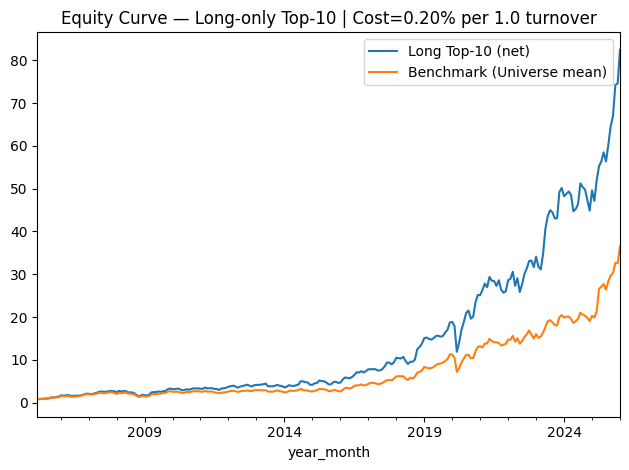

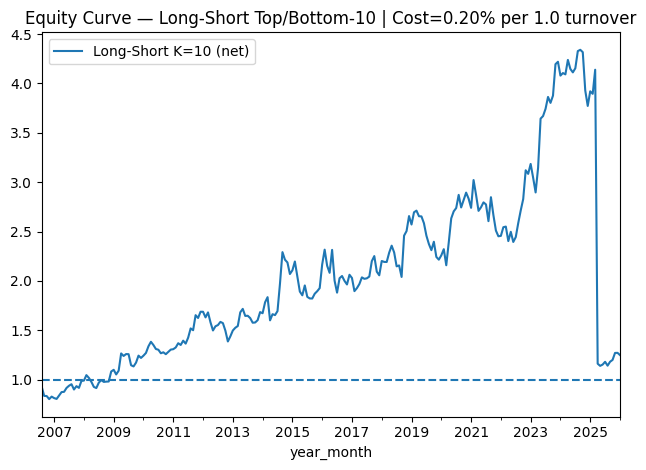

In [25]:
K_MAIN = 10  # escolha inicial; você pode trocar depois

long_df, ls_df = results[K_MAIN]
merged_long = long_df.join(bench, how="inner")
merged_ls = ls_df.join(bench, how="inner")

plt.figure()
(1 + merged_long[f"long_net_k{K_MAIN}"]).cumprod().plot(label=f"Long Top-{K_MAIN} (net)")
(1 + merged_long["bench_ret"]).cumprod().plot(label="Benchmark (Universe mean)")
plt.title(f"Equity Curve — Long-only Top-{K_MAIN} | Cost={COST*100:.2f}% per 1.0 turnover")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
(1 + merged_ls[f"ls_net_k{K_MAIN}"]).cumprod().plot(label=f"Long-Short K={K_MAIN} (net)")
plt.axhline(1, linestyle="--")
plt.title(f"Equity Curve — Long-Short Top/Bottom-{K_MAIN} | Cost={COST*100:.2f}% per 1.0 turnover")
plt.legend()
plt.tight_layout()
plt.show()

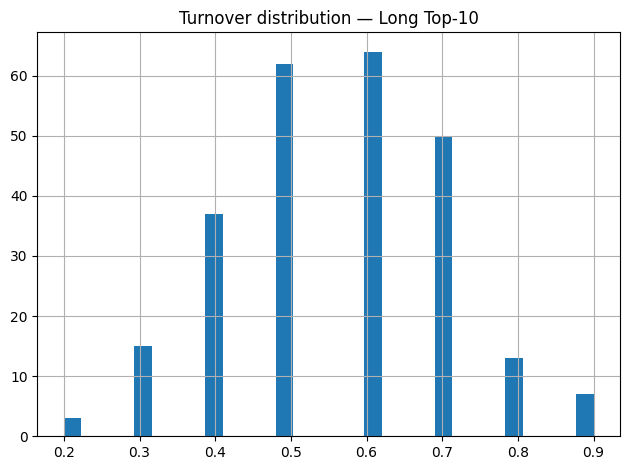

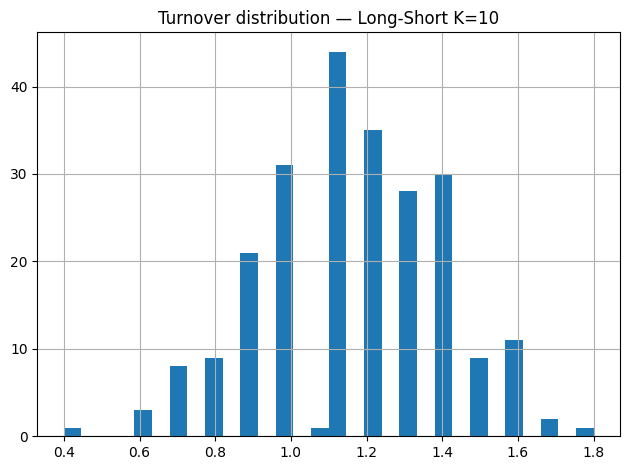

In [26]:
plt.figure()
merged_long[f"long_to_k{K_MAIN}"].hist(bins=30)
plt.title(f"Turnover distribution — Long Top-{K_MAIN}")
plt.tight_layout()
plt.show()

plt.figure()
merged_ls[f"ls_to_k{K_MAIN}"].hist(bins=30)
plt.title(f"Turnover distribution — Long-Short K={K_MAIN}")
plt.tight_layout()
plt.show()

## Como interpretar

- **Long-only** bate o benchmark quando o ranking encontra ações relativamente melhores do que a média do universo.
- **Long-short** é um teste mais “científico” do sinal: se for positivo após custos, o modelo realmente ordena bem (independente do mercado subir/cair).
- **Turnover alto** tende a destruir estratégia quando colocamos custos. Por isso medimos e descontamos custo por mês.

Regra prática:
- Se Long-short (net) for consistentemente > 0 com Sharpe razoável, o sinal é forte.
- Se apenas Long-only funciona, pode ser que parte do resultado venha do beta do mercado.

## Segunda análise

In [27]:
# =========================
# SUBPERÍODOS (K=5) — Long-only e Long-short (net)
# =========================

K_SUB = 5

# pega os resultados já calculados
long_df, ls_df = results[K_SUB]
merged_long = long_df.join(bench, how="inner")
merged_ls   = ls_df.join(bench, how="inner")

def perf_stats(returns: pd.Series) -> dict:
    returns = returns.dropna()
    equity = (1 + returns).cumprod()
    cum = float(equity.iloc[-1] - 1) if len(equity) else np.nan
    mean = float(returns.mean()) if len(returns) else np.nan
    vol = float(returns.std()) if len(returns) else np.nan
    sharpe = float(mean / vol * np.sqrt(12)) if vol and vol > 0 else np.nan
    dd = (equity / equity.cummax()) - 1
    max_dd = float(dd.min()) if len(dd) else np.nan
    return {"Months": int(len(returns)), "Cumulative": cum, "Mean": mean, "Vol": vol, "Sharpe": sharpe, "MaxDD": max_dd}

def slice_period(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    # year_month é PeriodIndex; vamos comparar por timestamp
    idx = df.index.to_timestamp()
    mask = (idx >= pd.Timestamp(start)) & (idx <= pd.Timestamp(end))
    return df.loc[mask].copy()

# Subperíodos (ajuste se quiser)
periods = [
    ("2005-01-01", "2012-12-31", "2005–2012"),
    ("2013-01-01", "2018-12-31", "2013–2018"),
    ("2019-01-01", "2026-12-31", "2019–2026"),
]

rows = []

for start, end, label in periods:
    a = slice_period(merged_long, start, end)
    b = slice_period(merged_ls, start, end)

    r_long = a[f"long_net_k{K_SUB}"]
    r_ls   = b[f"ls_net_k{K_SUB}"]

    # hit rates
    hit_long = float((a[f"long_net_k{K_SUB}"] > a["bench_ret"]).mean()) if len(a) else np.nan
    hit_ls   = float((b[f"ls_net_k{K_SUB}"] > 0).mean()) if len(b) else np.nan

    rows.append({
        "Period": label,
        "Strategy": f"Long-only Top-{K_SUB} (net)",
        **perf_stats(r_long),
        "AvgTurnover": float(a[f"long_to_k{K_SUB}"].mean()) if len(a) else np.nan,
        "HitRate": hit_long
    })
    rows.append({
        "Period": label,
        "Strategy": f"Long-Short K={K_SUB} (net)",
        **perf_stats(r_ls),
        "AvgTurnover": float(b[f"ls_to_k{K_SUB}"].mean()) if len(b) else np.nan,
        "HitRate": hit_ls
    })

subperiod_summary = pd.DataFrame(rows).sort_values(["Strategy", "Period"]).reset_index(drop=True)
subperiod_summary

,Period,Strategy,Months,Cumulative,Mean,Vol,Sharpe,MaxDD,AvgTurnover,HitRate
0,2005–2012,Long-Short K=5 (net),94,1.066594,0.009659,0.063180,0.529588,-0.366397,1.453191,0.500000
1,2013–2018,Long-Short K=5 (net),72,2.148783,0.019654,0.085766,0.793814,-0.308507,1.536111,0.611111
2,2019–2026,Long-Short K=5 (net),85,-2.286199,-0.002840,0.172815,-0.056929,-1.467567,1.390588,0.529412
3,2005–2012,Long-only Top-5 (net),94,2.571047,0.016758,0.081156,0.715299,-0.439120,0.724468,0.542553
4,2013–2018,Long-only Top-5 (net),72,3.956789,0.025481,0.079434,1.111230,-0.287027,0.747222,0.611111
5,2019–2026,Long-only Top-5 (net),85,7.130223,0.028987,0.090197,1.113279,-0.384732,0.630588,0.482353


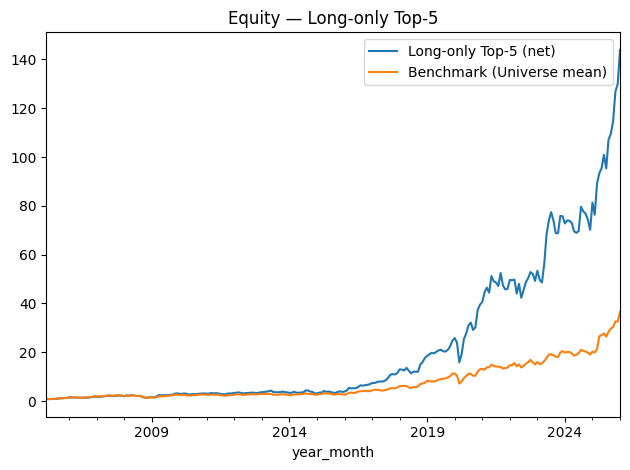

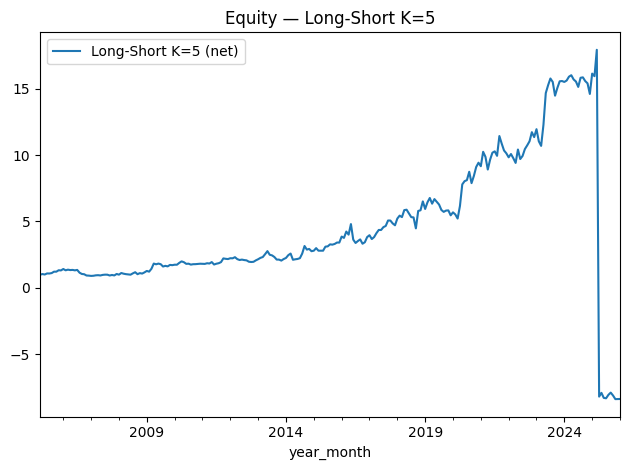

In [28]:
# =========================
# EQUITY CURVES (K=5) — por subperíodo
# =========================

plt.figure()
(1 + merged_long[f"long_net_k{K_SUB}"]).cumprod().plot(label=f"Long-only Top-{K_SUB} (net)")
(1 + merged_long["bench_ret"]).cumprod().plot(label="Benchmark (Universe mean)")
plt.title(f"Equity — Long-only Top-{K_SUB}")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
(1 + merged_ls[f"ls_net_k{K_SUB}"]).cumprod().plot(label=f"Long-Short K={K_SUB} (net)")
plt.title(f"Equity — Long-Short K={K_SUB}")
plt.legend()
plt.tight_layout()
plt.show()

## Terceira Análise

In [29]:
# =========================
# SENSIBILIDADE A CUSTO (K=5) — Long-only e Long-short (net)
# =========================

K_COST = 5
COST_LIST = [0.001, 0.002, 0.003, 0.005]  # 0.10%, 0.20%, 0.30%, 0.50% por 1.0 turnover

# Bench (igual já usado)
bench = preds_m.groupby("year_month")["y_true"].mean().rename("bench_ret").to_frame()

def perf_stats(returns: pd.Series) -> dict:
    returns = returns.dropna()
    equity = (1 + returns).cumprod()
    cum = float(equity.iloc[-1] - 1) if len(equity) else np.nan
    mean = float(returns.mean()) if len(returns) else np.nan
    vol = float(returns.std()) if len(returns) else np.nan
    sharpe = float(mean / vol * np.sqrt(12)) if vol and vol > 0 else np.nan
    dd = (equity / equity.cummax()) - 1
    max_dd = float(dd.min()) if len(dd) else np.nan
    return {"Months": int(len(returns)), "Cumulative": cum, "Mean": mean, "Vol": vol, "Sharpe": sharpe, "MaxDD": max_dd}

rows = []

for cost in COST_LIST:
    # rodar backtest com o custo atual
    long_df = backtest(preds_m, k=K_COST, mode="long", cost_per_1_turnover=cost)
    ls_df   = backtest(preds_m, k=K_COST, mode="ls", cost_per_1_turnover=cost)

    merged_long = long_df.join(bench, how="inner")
    merged_ls   = ls_df.join(bench, how="inner")

    r_long = merged_long["net_ret"]
    r_ls   = merged_ls["net_ret"]

    hit_long = float((merged_long["net_ret"] > merged_long["bench_ret"]).mean())
    hit_ls   = float((merged_ls["net_ret"] > 0).mean())

    rows.append({
        "Cost_per_1.0_turnover": cost,
        "Strategy": f"Long-only Top-{K_COST} (net)",
        **perf_stats(r_long),
        "AvgTurnover": float(merged_long["turnover"].mean()),
        "HitRate": hit_long
    })
    rows.append({
        "Cost_per_1.0_turnover": cost,
        "Strategy": f"Long-Short K={K_COST} (net)",
        **perf_stats(r_ls),
        "AvgTurnover": float(merged_ls["turnover"].mean()),
        "HitRate": hit_ls
    })

cost_sensitivity = pd.DataFrame(rows).sort_values(["Strategy", "Cost_per_1.0_turnover"]).reset_index(drop=True)
cost_sensitivity

,Cost_per_1.0_turnover,Strategy,Months,Cumulative,Mean,Vol,Sharpe,MaxDD,AvgTurnover,HitRate
0,0.001,Long-Short K=5 (net),251,-12.967600,0.009749,0.116994,0.288659,-1.471026,1.455777,0.573705
1,0.002,Long-Short K=5 (net),251,-9.369623,0.008293,0.116998,0.245545,-1.467567,1.455777,0.541833
2,0.003,Long-Short K=5 (net),251,-6.850091,0.006837,0.117003,0.202433,-1.464682,1.455777,0.533865
3,0.005,Long-Short K=5 (net),251,-3.853296,0.003926,0.117016,0.116219,-1.462726,1.455777,0.517928
4,0.001,Long-only Top-5 (net),251,170.045104,0.024101,0.083687,0.997622,-0.435908,0.699203,0.549801
5,0.002,Long-only Top-5 (net),251,142.912467,0.023402,0.083690,0.968636,-0.439120,0.699203,0.541833
6,0.003,Long-only Top-5 (net),251,120.068141,0.022702,0.083695,0.939647,-0.442316,0.699203,0.541833
7,0.005,Long-only Top-5 (net),251,84.649236,0.021304,0.083705,0.881664,-0.448663,0.699203,0.521912


<Figure size 640x480 with 0 Axes>

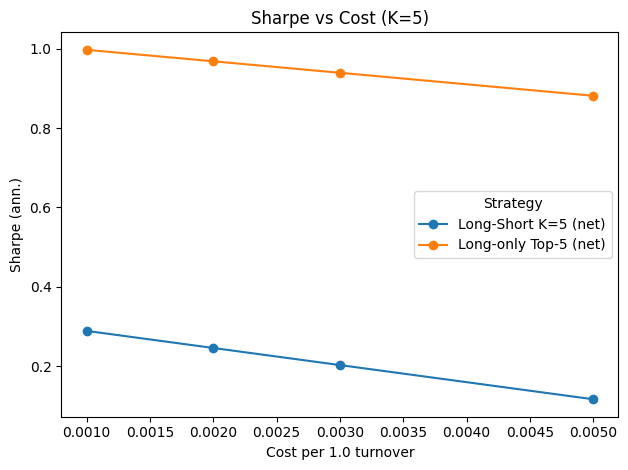

In [30]:
# =========================
# PLOT: SHARPE vs CUSTO
# =========================

pivot = cost_sensitivity.pivot(index="Cost_per_1.0_turnover", columns="Strategy", values="Sharpe")

plt.figure()
pivot.plot(marker="o")
plt.title(f"Sharpe vs Cost (K={K_COST})")
plt.xlabel("Cost per 1.0 turnover")
plt.ylabel("Sharpe (ann.)")
plt.tight_layout()
plt.show()